{/* cspell:ignore blackbox  Hadamards  couterintuitive */}

# The Deutsch-Jozsa algorithm

For this Qiskit in Classrooms module, students must have a working Python environment with the following packages installed:
- `qiskit` v2.1.0 or newer
- `qiskit-ibm-runtime` v0.40.1 or newer
- `qiskit-aer` v0.17.0 or newer
- `qiskit.visualization`

To set up and install the packages above, see the [Install Qiskit](/docs/guides/install-qiskit) guide.
In order to run jobs on real quantum computers, students will need to set up an account with IBM Quantum&reg; by following the steps in the [Set up your IBM Cloud account](/docs/guides/cloud-setup) guide.

This module was tested and used 4 sec. of QPU time. This is a good-faith estimate; your actual usage may vary.

Watch the module walkthrough by Dr. Katie McCormick below, or click [here](https://youtu.be/QcK0GK7DUh8?si=8e0Lmjgylxmgl2y7) to watch it on YouTube.

-------


<IBMVideo id="134413695" title="Katie McCormick introduces one of the first quantum algorithms developed: the Deutsch algorithm and its extension, the Deutsch-Jozsa algorithm."/>

## 1. Intro

In the early 1980's, quantum physicists and computer scientists had a vague notion that quantum mechanics could be harnessed to make computations that were far more powerful than classical computers can make. Their reasoning was this: it's difficult for a classical computer to simulate quantum systems, but a *quantum* computer should be able to do it more efficiently. And if a quantum computer could simulate quantum systems more efficiently, perhaps there were other tasks that it could perform more efficiently than a classical computer.

The logic was sound, but the details remained to be worked out. This began in 1985, when David Deutsch described the first "universal quantum computer." In this same paper, he provided the first example problem for which a quantum computer could solve something more efficiently than a classical computer could. This first toy example is now known as "Deutsch's algorithm." The improvement in Deutsch's algorithm was modest, but Deutsch worked with Richard Jozsa a few years later to further widen the gap between classical and quantum computers.

These algorithms — Deutsch's, and the Deutsch-Jozsa extension — are not particularly useful, but they are still really important for a few reasons:

1. Historically, they were some of the first quantum algorithms that were demonstrated to beat their classical counterparts. Understanding them can help us understand how the community's thinking on quantum computing has evolved over time.
2. They can help us understand some aspects of the answer to a surprisingly subtle question: What gives quantum computing its power? Sometimes, quantum computers are compared to giant, exponentially-scaling parallel processors. But this isn't quite right. While a piece of the answer to this question lies in so-called "quantum parallelism," extracting as much information as possible in a single run is a subtle art. The Deutsch and Deutsch-Jozsa algorithms show how this can be done.

In this module, we'll learn about Deutsch's algorithm, the Deutsch-Jozsa algorithm, and what they teach us about the power of quantum computing.

## 2. Quantum parallelism and its limits

Part of the power of quantum computing is derived from "quantum parallelism." which is essentially the ability to perform operations on multiple inputs at the same time, since the qubit input states could be in a superposition of multiple classically allowed states. HOWEVER, while a quantum circuit might be able to evaluate multiple input states at once, extracting all of that information in one go is impossible.

To see what I mean here, let's say we have a bit, $x$ and some function applied to that bit, $f(x)$. There are four possible binary functions taking a single bit to another single bit:

| $x$    |  $f_1(x)$ | $f_2(x)$ | $f_3(x)$ | $f_4(x)$ |
| ----------- | ------- |-------| -------- | ------- |
| 0  | 0   | 0  | 1   | 1 |
| 1  | 0   | 1  | 0 | 1 |

We'd like to find out which of these functions (1-4) our $f(x)$ is. Classically, we would need to run the function twice — once for $x=0$, once for $x=1$. But let's see if we can do better with a quantum circuit. We can learn about the function with the following gate:

![quantum_parallelism](/learning/images/modules/computer-science/deutsch-jozsa/quantum-parallelism.avif)

Here, the $U_f$ gate computes $f(x)$, where $x$ is the state of qubit 0, and applies that to qubit 1. So, the resulting state, $|x\rangle|y\oplus f(x)\rangle$, simply becomes $|x\rangle|f(x)\rangle$ when $|y\rangle = |0\rangle$. This contains all the information we need to know the function $f(x)$: qubit 0 tells us what $x$ is, and qubit 1 tells us what $f(x)$ is. So, if we initialize $|x\rangle = \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$, then the final state of both qubits will be: $|y\rangle|x\rangle = \frac{1}{\sqrt{2}}(|f(0)\rangle|0\rangle+|f(1)\rangle|1\rangle)$. But how do we access that information?

### 2.1. Try it on Qiskit:

Using Qiskit we'll randomly select one of the four possible functions above and run the circuit. Then your task is to use the measurements of the quantum circuit to learn the function in as few runs as possible.

In this first experiment and throughout the module, we will use a framework for quantum computing known as "Qiskit patterns", which breaks workflows into the following steps:

- Step 1: Map classical inputs to a quantum problem
- Step 2: Optimize problem for quantum execution
- Step 3: Execute using Qiskit Runtime Primitives
- Step 4: Post-processing and classical analysis

First, let's start by loading some necessary packages, including Runtime primitives. We will also select the least-busy quantum computer available to us.

In [1]:
# Load the Qiskit Runtime service
from qiskit_ibm_runtime import QiskitRuntimeService

# Load the Runtime primitive and session
from qiskit_ibm_runtime import SamplerV2 as Sampler


service = QiskitRuntimeService(channel="ibm_quantum_platform")

# Use the least busy backend, or uncomment the loading of a specific backend like "ibm_brisbane".
# backend = service.least_busy(operational=True, simulator=False, min_num_qubits = 127)
backend = service.backend("ibm_brisbane")
print(backend.name)


sampler = Sampler(mode=backend)

ibm_brisbane


The cell below will allow you to switch between using the simulator or real hardware throughout the notebook. We recommend running it now:

In [2]:
# Load the backend sampler
from qiskit.primitives import BackendSamplerV2

# Load the Aer simulator and generate a noise model based on the currently-selected backend.
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

# Alternatively, load a fake backend with generic properties and define a simulator.
from qiskit.providers.fake_provider import GenericBackendV2


noise_model = NoiseModel.from_backend(backend)

# Define a simulator using Aer, and use it in Sampler.
backend_sim = AerSimulator(noise_model=noise_model)
sampler_sim = BackendSamplerV2(backend=backend_sim)


backend_gen = GenericBackendV2(num_qubits=18)
sampler_gen = BackendSamplerV2(backend=backend_gen)

Now that we've loaded the necessary packages, we can proceed with the Qiskit patterns workflow. In the mapping step below, we first make function that selects among the four possible functions taking a single bit to another single bit.

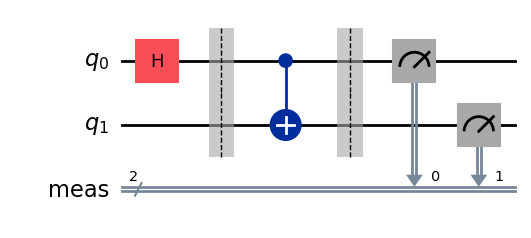

In [3]:
# Step 1: Map

from qiskit import QuantumCircuit

qc = QuantumCircuit(2)


def twobit_function(case: int):
    """
    Generate a valid two-bit function as a `QuantumCircuit`.
    """
    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")

    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f


# first, convert oracle circuit (above) to a single gate for drawing purposes. otherwise, the circuit is too large to display
# blackbox = twobit_function(2).to_gate()  # you may edit the number inside "twobit_function()" to select among the four valid functions
# blackbox.label = "$U_f$"

qc.h(0)
qc.barrier()
qc.compose(twobit_function(2), inplace=True)
qc.measure_all()


qc.draw("mpl")

In the above circuit, the Hadamard gate "H" takes qubit 0, which is initially in the state $|0\rangle$, to the superposition state $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$. Then, $U_f$ evaluates the function $f(x)$ and applies that to qubit 1.

Next we need to optimize and transpile the circuit to be run on the quantum computer:

In [4]:
# Step 2: Transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

qc_isa = pm.run(qc)

Finally, we execute our transpiled circuit on the quantum computer and visualize our results:

In [5]:
# Step 3: Run the job on a real quantum computer

job = sampler.run([qc_isa], shots=1)
# job = sampler_sim.run([qc_isa],shots=1) # uncomment this line to run on simulator instead
res = job.result()
counts = res[0].data.meas.get_counts()

# job = sampler_gen.run([qc_isa],shots=1)
# res=job.result()
# counts=res[0].data.c.get_counts()

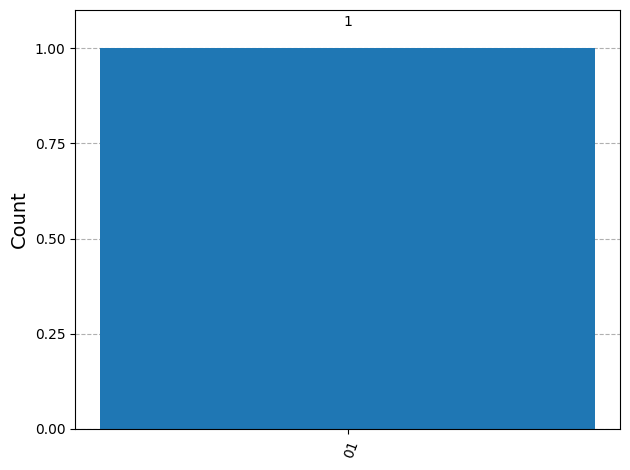

In [6]:
# Step 4: Visualize and analyze results

## Analysis
from qiskit.visualization import plot_histogram

plot_histogram(counts)

The above is a histogram of our results. Depending on the number of shots you chose to run the circuit in step 3 above, you could see one or two bars, representing the measured states of the two qubits in each shot. As always with Qiskit and in this notebook, we use "little endian" notation, meaning the states of qubits 0 through n are written in ascending order from right to left, so qubit 0 is always farthest right.

So, because qubit 0 was in a superposition state, the circuit evaluated the function for *both* $x=0$ and $x=1$ *at the same time* — something classical computers cannot do! But the catch comes when we want to learn about the function $f(x)$ — when we measure the qubits, we collapse their state. If you select "shots = 1" to only run the circuit once, you will only see one bar in the histogram above, and your information about the function will be incomplete.

#### Check your understanding
Read the question(s) below, think about your answer, then click the triangle to reveal the solution.
<details>
<summary>

How many times must we run the above algorithm to learn the function $f(x)$? Is this any better than the classical case? Would you rather have a classical or quantum computer to solve this problem?

</summary>

__Answer:__


Since the measurement will collapse the superposition and return only one value, we need to run the circuit *at least* twice to return both outputs of the function $f(0)$ and $f(1)$. Best case, this performs as well as the classical case, where we compute both $f(0)$ and $f(1)$ in the first two queries. But there's a chance that we'll need to run it more than two times, since the final measurement is probabilistic and might return the same $f(x)$ value the first two times. I would rather have a classical computer in this case.

</details>


So, while quantum parallelism can be powerful when used in the right way, it is not correct to say that a quantum computer works just like a massive, classical parallel processor. The act of measurement collapses the quantum states, so we can only ever access a single output of the computation.

## 3. Deutsch's Algorithm

While quantum parallelism alone doesn't give us an advantage over classical computers, we can pair this with another quantum phenomena, interference, to achieve a speed-up. The algorithm now known as "Deutsch's algorithm" is the first example of an algorithm that accomplishes this.

### 3.1. The Problem

Here was the problem:

Given an input bit, $x = \{0,1\}$, and an input function $f(x) = \{0,1\}$, determine whether the function is *balanced* or *constant*. That is, if it's balanced, then the output of the function is 0 half the time and 1 the other half the time. If it's constant, then the output of the function is either always 0 or always 1. Recall the table of four possible functions taking a single bit to another a single bit:


| $x$    |  $f_1(x)$ | $f_2(x)$ | $f_3(x)$ | $f_4(x)$ |
| ----------- | ------- |-------| -------- | ------- |
| 0  | 0   | 0  | 1   | 1 |
| 1  | 0   | 1  | 0 | 1 |

The first and the last functions, $f_1(x)$ and $f_4(x)$, are constant, while the middle two functions, $f_2(x)$ and $f_3(x)$, are balanced.

### 3.2 The Algorithm

The way Deutsch approached this problem was through the "query model." In the query model, the input function ($f_i(x)$ above) is contained in a "black box" — we don't have direct access to its contents, but we can query the black box and it will give us the output of the function. We sometimes say that an "oracle" provides this information. See [Lesson 1: Quantum Query Algorithms](/learning/courses/fundamentals-of-quantum-algorithms/quantum-query-algorithms/introduction) of the Fundamentals of Quantum Algorithms course for more on the query model.

To determine whether a quantum algorithm is more efficient than a classical algorithm in the query model, we can simply compare the number of queries we need to make of the black box in each case. In the classical case, in order to know if the function contained in the black box were balanced or constant, we would need to query the box two times to get both $f(0)$ and $f(1)$.

In Deutsch's quantum algorithm, though, he found a way to get the information with only one query! He made one adjustment to the "quantum parallelism" circuit above, so that he prepared a superposition state on *both* qubits, instead of only on qubit 0. Then the two outputs of the function, $f(0)$ and $f(1)$ interfered to return 0 if they were either both 0 or both 1 (the function was constant), and returned 1 if they were different (the function was balanced). In this way, Deutsch could differentiate between a constant and a balanced function with a single query.

Here's a circuit diagram of Deutsch's algorithm:

![Circuit diagram of Deutsch's algorithm](/learning/images/modules/computer-science/deutsch-jozsa/Deutsch_algo.avif)

To understand how this algorithm works, let's look at the quantum states of the qubits at the three points noted on the diagram above. Try to work out the states for yourself before clicking to view the answers:


#### Check your understanding
Read the questions below, think about your answers, then click the triangles to reveal the solutions.
<details>
<summary>

What is the state $|\pi_1\rangle$?

</summary>

__Answer:__

Applying a Hadamard transforms the state $|0\rangle$ to $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ and the state $|1\rangle$ to  $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$. So, the full state becomes: $|\pi_1\rangle = [\frac{|0\rangle-|1\rangle}{\sqrt{2}}][\frac{|0\rangle+|1\rangle}{\sqrt{2}}]$

</details>

<details>
<summary>

What is the state $|\pi_2\rangle$?

</summary>

__Answer:__


Before we apply $U_f$, remember what it does. It will change the state of qubit 1 based on the state of qubit 0. So, it makes sense to factor the state of qubit 0 out: $|\pi_1\rangle = \frac{1}{2} (|0\rangle-|1\rangle)|0\rangle+\frac{1}{2}(|0\rangle-|1\rangle)|1\rangle$. Then, if $f(0)=f(1)$, the two terms will transform in the same way and the relative sign between the two terms remains positive, but if $f(0)\neq f(1)$, then that means the second term will pick up a minus sign relative to the first term, changing the state of qubit 0 from $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ to $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$. So:
$$
|\pi_2\rangle = \begin{cases}
\pm[\frac{|0\rangle-|1\rangle}{\sqrt{2}}][\frac{|0\rangle+|1\rangle}{\sqrt{2}}] & \text{if} & f(0) = f(1) \\
\pm[\frac{|0\rangle-|1\rangle}{\sqrt{2}}][\frac{|0\rangle-|1\rangle}{\sqrt{2}}] &\text{if} & f(0) \neq f(1) \\
\end{cases}
$$

</details>

<details>
<summary>

What is the state $|\pi_3\rangle$?

</summary>

__Answer:__

Now, the state of qubit 0 is either $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ or $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$, depending on the function. Applying the Hadamard will yield either $|0\rangle$ or $|1\rangle$, respectively.

$$
|\pi_3\rangle = \begin{cases}
\pm[\frac{|0\rangle-|1\rangle}{\sqrt{2}}]|0\rangle & \text{if} & f(0) = f(1) \\
\pm[\frac{|0\rangle-|1\rangle}{\sqrt{2}}]|1\rangle &\text{if} & f(0) \neq f(1) \\
\end{cases}
$$

</details>


Looking through your answers for the above questions, note that something a bit surprising happens. Although $U_f$ does nothing explicitly to the state of qubit 0, because it changes qubit 1 based on the state of qubit 0, it can happen that this causes a phase shift in qubit 0. This is known as the "phase-kickback" phenomenon, and is discussed in more detail in [Lesson 1: Quantum Query Algorithms](/learning/courses/fundamentals-of-quantum-algorithms/quantum-query-algorithms/introduction) of the Fundamentals of Quantum Algorithms course.

Now that we understand how this algorithm works, let's implement it with Qiskit.

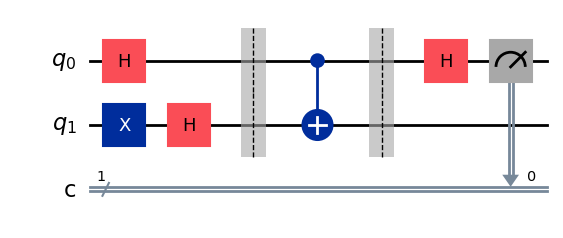

In [7]:
## Deutsch's algorithm:

## Step 1: Map the problem

# first, convert oracle circuit (above) to a single gate for drawing purposes. otherwise, the circuit is too large to display
blackbox = twobit_function(
    3
).to_gate()  # you may edit the number (1-4) inside "twobit_function()" to select among the four valid functions
blackbox.label = "$U_f$"


qc_deutsch = QuantumCircuit(2, 1)

qc_deutsch.x(1)
qc_deutsch.h(range(2))

qc_deutsch.barrier()
qc_deutsch.compose(twobit_function(2), inplace=True)
qc_deutsch.barrier()

qc_deutsch.h(0)
qc_deutsch.measure(0, 0)

qc_deutsch.draw("mpl")

In [8]:
# Step 2: Transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

qc_isa = pm.run(qc_deutsch)

In [9]:
# Step 3: Run the job on a real quantum computer

job = sampler.run([qc_isa], shots=1)
# job = sampler_sim.run([qc_isa],shots=1) # uncomment this line to run on simulator instead
res = job.result()
counts = res[0].data.c.get_counts()

# job = sampler_gen.run([qc_isa],shots=1)
# res=job.result()
# counts=res[0].data.c.get_counts()

In [10]:
# Step 4: Visualize and analyze results

## Analysis
print(counts)
if "1" in counts:
    print("balanced")
else:
    print("constant")

{'1': 1}
balanced


## 4. The Deutsch-Jozsa algorithm

Deutsch's algorithm was an important first step in demonstrating how a quantum computer might be more efficient than a classical computer, but it was only a modest improvement: it required just one query, compared to two in the classical case. In 1992, Deutsch and his colleague, Richard Jozsa, extended the original two-qubit algorithm to more qubits. The problem remained the same: determine whether a function is *balanced* or *constant*. But this time, the function goes from $n$ bits to a single bit. Either the function returns 0 and 1 an equal number of times (it's *balanced*) or the function returns always 1 or always 0 (it's *constant*).

Here's a circuit diagram of the algorithm:

![DJ_algo.png](/learning/images/modules/computer-science/deutsch-jozsa/DJ_algo.avif)

This algorithm works in the same way as Deutsch's algorithm: the phase-kickback allows one to read out the state of qubit 0 to determine whether the function is constant or balanced. It's a bit trickier to see than for the two-qubit Deutsch's algorithm case, since the states will include sums over the $n$ qubits, and so working out those states will be left as an optional exercise for you at the end of the module. The algorithm will return a bitstring of all 0's if the function is constant, and a bitstring containing at least one 1 if the function is balanced.

To see how the algorithm works in Qiskit, first, we need to generate our oracle: the random function that is guaranteed to be either constant or balanced. The code below will generate a balanced function 50% of the time, and a constant function 50% of the time. Don't worry if you don't entirely follow the code — it's complicated and not necessary for our understanding of the quantum algorithm.

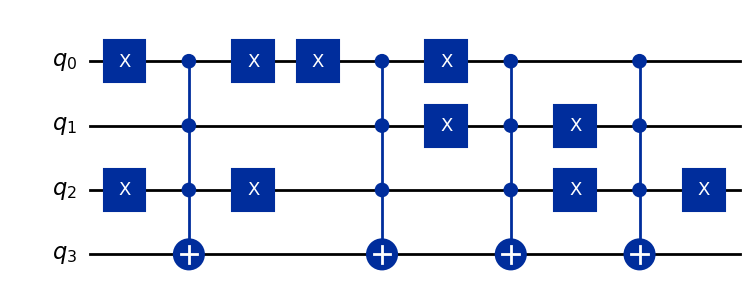

In [11]:
from qiskit import QuantumCircuit
import numpy as np


def dj_function(num_qubits):
    """
    Create a random Deutsch-Jozsa function.
    """

    qc_dj = QuantumCircuit(num_qubits + 1)
    if np.random.randint(0, 2):
        # Flip output qubits with 50% chance
        qc_dj.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance.
        return qc_dj

    # If the "if" statement above was "TRUE" then we've returned the constant
    # function and the function is complete. If not, we proceed in creating our
    # balanced function. Everything below is to produce the balanced function:

    # select half of all possible states at random:
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )

    def add_cx(qc_dj, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc_dj.x(qubit)
        return qc_dj

    for state in on_states:
        # qc_dj.barrier()  # Barriers are added to help visualize how the functions are created. They can safely be removed.
        qc_dj = add_cx(qc_dj, f"{state:0b}")
        qc_dj.mcx(list(range(num_qubits)), num_qubits)
        qc_dj = add_cx(qc_dj, f"{state:0b}")

    # qc_dj.barrier()

    return qc_dj


n = 3  # number of input qubits

oracle = dj_function(n)

display(oracle.draw("mpl"))

This is the oracle function, which is either balanced or constant. Can you see by looking at it whether the output on the last qubit depends on the values put in for the first $n$ qubits? If the output for the last qubit depends on the first $n$ qubits, can you tell if that dependent output is balanced or not?

We can tell whether the function is balanced or constant by looking at the above circuit, but remember, for the sake of this problem, we think of this function as a "black box." We can't peek into the box to look at the circuit diagram. Instead, we need to query the box.

To query the box, we use the Deutsch-Jozsa algorithm and determine whether the function is constant or balanced:

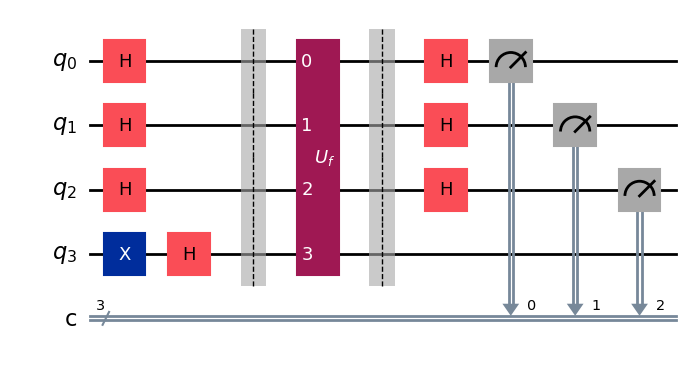

In [12]:
blackbox = oracle.to_gate()
blackbox.label = "$U_f$"


qc_dj = QuantumCircuit(n + 1, n)
qc_dj.x(n)
qc_dj.h(range(n + 1))
qc_dj.barrier()
qc_dj.compose(blackbox, inplace=True)
qc_dj.barrier()
qc_dj.h(range(n))
qc_dj.measure(range(n), range(n))

qc_dj.decompose().decompose()


qc_dj.draw("mpl")

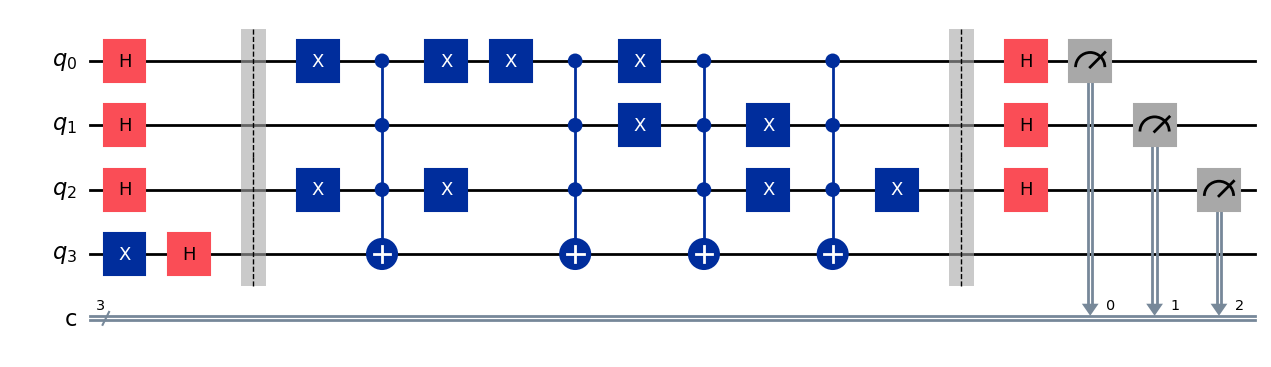

In [13]:
# Step 1: Map the problem

qc_dj = QuantumCircuit(n + 1, n)
qc_dj.x(n)
qc_dj.h(range(n + 1))
qc_dj.barrier()
qc_dj.compose(oracle, inplace=True)
qc_dj.barrier()
qc_dj.h(range(n))
qc_dj.measure(range(n), range(n))

qc_dj.decompose().decompose()


qc_dj.draw("mpl")

In [14]:
# Step 2: Transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

qc_isa = pm.run(qc_dj)

In [15]:
# Step 3: Run the job on a real quantum computer

job = sampler.run([qc_isa], shots=1)
# job = sampler_sim.run([qc_isa],shots=1) # uncomment this line to run on simulator instead
res = job.result()
counts = res[0].data.c.get_counts()

# job = sampler_gen.run([qc_isa],shots=1)
# res=job.result()
# counts=res[0].data.c.get_counts()

In [16]:
# Step 4: Visualize and analyze results

## Analysis
print(counts)

if (
    "0" * n in counts
):  # The D-J algorithm returns all zeroes if the function was constant
    print("constant")
else:
    print("balanced")  # anything other than all zeroes means the function is balanced.

{'110': 1}
balanced


Above, the first line of the output is the bitstring of measurement outcomes. The second line outputs whether the bitstring implies that the function was balanced or constant. If the bitstring contained all zeroes, then it was constant; if not, it was balanced. So, with just a single run of the above quantum circuit, we can determine whether the function is constant or balanced!

#### Check your understanding
Read the questions below, think about your answers, then click the triangles to reveal the solutions.

<details>
<summary>

How many queries would it take a classical computer to determine with 100% certainty whether a function were constant or balanced? Remember, classically, a single query only allows you to apply the function to a single bitstring.

</summary>

__Answer:__

There are $2^n$ possible bitstrings to check, and in the worst case, you would need to test $2^n/2+1$ of these. For example, if the function were constant, and you kept measuring "1" as the output of the function, then you couldn't be certain that it was truly constant until you checked over half of the results. Before then, you might have just been very unlucky to keep measuring "1" on a balanced function. It's like flipping a coin over and over and it landing heads every time. It's unlikely, but not impossible.

</details>

<details>
<summary>

How would your above answer change if you just had to just measure until one outcome (balanced or constant) is more likely than the other? How many queries would it take in this case?

</summary>

__Answer:__

In this case, you could just measure twice. If the two measurements are different, you know the function is balanced. If the two measurements are the same, then it could be balanced, or it could be constant. The probability that it's balanced with this set of measurements is: $\frac{1}{2}\frac{2^n /2 - 1}{2^n-1}$. This is less than 1/2, so it's more likely that the function is constant in this case.

</details>

So, the Deutsch-Jozsa algorithm demonstrated an exponential speed-up over a *deterministic* classical algorithm (one that returns the answer with 100% certainty), but no significant speed-up over a *probabilistic* one (one that returns a result that is *likely* to be the correct answer).

### 4.1. The Bernstein - Vazirani problem

In 1997, Ethan Bernstein and Umesh Vazirani used the Deutsch-Jozsa algorithm to solve a more specific, restricted problem compared to the Deutsch-Jozsa problem. Rather than simply try to distinguish between two different classes of functions, as in the D-J case, Bernstein and Vazirani used the Deutsch-Jozsa algorithm to actually learn a string encoded in a function. Here's the problem:

The function $f:\{0,1\}^n \rightarrow \{0,1\}$ still takes an $n$-bit string and outputs a single bit. But now, instead of promising that the function is balanced or constant, we're now promised that the function is the dot product between the input string $x$ and some secret $n$-bit string $s$, modulo 2. (This dot product modulo 2 is called the "binary dot product.") The problem is to figure out what the secret, $n$-bit string is.

Written another way, we're given a black-box function $f: {0,1}^n \rightarrow {0,1}$ that satisfies $f(x) = s \cdot x$ for some string $s$, and we want to learn the string $s$.


Let's take a look at how the D-J algorithm solves this problem:

1. First, a Hadamard gate is applied to the $n$ input qubits, and a NOT gate plus a Hadamard is applied to the output qubit, making the state:

$$
|\Psi\rangle = |-\rangle_{n} \otimes |+\rangle_{n-1} \otimes |+\rangle_{n-2} \otimes ... \otimes |+\rangle_0
$$

   The state of qubits 1 through $n$ can be written more simply as a sum over all $2^n$ the $n$-qubit basis states $|00...00\rangle, |00...01\rangle, |000...11\rangle, ..., |111...11\rangle$. We call the set of these basis states $\Sigma^n$. (See [Fundamentals of Quantum Algorithms](/learning/courses/fundamentals-of-quantum-algorithms/quantum-query-algorithms/deutsch-jozsa-algorithm) for more details.)

$$
|\Psi\rangle = |-\rangle \otimes \frac{1}{\sqrt{2^n}}\sum\limits_{x \in \Sigma^n}{|x\rangle}
$$

2. Next, the $U_f$ gate is applied to the qubits. This gate will take the first n qubits as input (which are now in an equal superposition of all possible n-bit strings) and applies the function $f(x)=s \cdot x$ to the output qubit, so that this qubit is now in the state: $ |- \oplus f(x)\rangle$. Thanks to the phase kickback mechanism, the state of this qubit remains unchanged, but some of the terms in the input qubit state pick up a minus sign:

$$
|\Psi\rangle = |-\rangle \otimes \frac{1}{\sqrt{2^n}}\sum\limits_{x \in \Sigma^n}{(-1)^{f(x)}|x\rangle}
$$

3. Now, the next set of Hadamards are applied to qubits 0 through $n-1$. Keeping track of the minus signs in this case can be tricky. It's helpful to know that applying a layer of Hadamards to $n$ qubits in a standard basis state $|x\rangle$ can be written as:

$$
H^{\otimes n} |x\rangle = \frac{1}{\sqrt{2^n}}\sum\limits_{y \in \Sigma^n}{(-1)^{x \cdot y}|y\rangle}
$$

So the state becomes:

$$
|\Psi\rangle = |-\rangle \otimes \frac{1}{2^n}\sum\limits_{x \in \Sigma^n}\sum\limits_{y \in \Sigma^n}{(-1)^{(s \cdot x) + (x \cdot y)}|y\rangle}
$$

4. Next step is to measure the first $n$ bits. But what will we measure? It turns out that the state above simplifies to:  $|\Psi\rangle = |-\rangle \otimes |s\rangle$, but that's far from obvious. If you'd like to follow through the math, see John Watrous' [Fundamentals of Quantum Algorithms](/learning/courses/fundamentals-of-quantum-algorithms/quantum-query-algorithms/deutsch-jozsa-algorithm#the-bernstein-vazirani-problem) course. The point is, though, that the phase kickback mechanism leads to the input qubits being in the state $|s\rangle$. So, to find out what the secret string $s$ was, you simply need to measure the qubits!


#### Check your understanding
Read the questions below, think about your answers, then click the triangles to reveal the solutions.

<details>
<summary>

Verify that the state from Step 3 above is indeed the state $|s\rangle$ for the special case of $n=1$.

</summary>

__Answer:__

When you explicitly write out the two summations, you should get a state with four terms (let's omit the output state $|-\rangle$ for this):

$$
|\Psi\rangle = \frac{1}{2}[|0\rangle + (-1)^s |0\rangle + |1\rangle + (-1)^{(s+1)} |1\rangle]
$$

If $s=0$, then the first two terms add constructively and the last two terms cancel, leaving us with $|\Psi\rangle = |0\rangle$. If $s=1$, then the last two terms add constructively and the first two terms cancel, leaving us with $|\Psi\rangle = |1\rangle$. So, in either case, $|\Psi\rangle = |s\rangle$. Hopefully this simplest case gives you a sense for how the general case with $n$ qubits works: all terms that are not $|s\rangle$ interfere away, leaving just the state $|s\rangle$.

</details>

<details>
<summary>
How can the same algorithm solve both the Bernstein-Vazirani and Deutsch-Jozsa problems? To make sense of this, think about Bernstein-Vazirani functions, which are of the form $f(x) = s \cdot x$. Are these functions also Deutsch-Jozsa functions? That is, determine whether functions of this form satisfy the Deutsch-Jozsa problem promise: that they're either *constant* or *balanced*. How does this help us understand how the same algorithm solves two different problems?

</summary>

__Answer:__

Every Bernstein-Vazirani function of the form $f(x) = s \cdot x$ also satisfies the Deutsch-Jozsa problem promise: if s=00...00, then the function is constant (always returns 0 for every string x). If s is any other string, then the function is balanced. So, applying the Deutsch-Jozsa algorithm to one of these functions simultaneously solves both problems! It returns the string, and if that string is 00...00 then we know it's constant; if there's at least one "1" in the string, we know it's balanced.

</details>

We can also verify that this algorithm successfully solves the Bernstein-Vazirani problem by testing it experimentally. First, we create the B-V function that lives inside the black box:

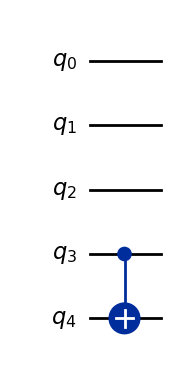

In [17]:
# Step 1: Map the problem


def bv_function(s):
    """
    Create a Bernstein-Vazirani function from a string of 1s and 0s.
    """
    qc = QuantumCircuit(len(s) + 1)
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(index, len(s))
    return qc


display(bv_function("1000").draw("mpl"))

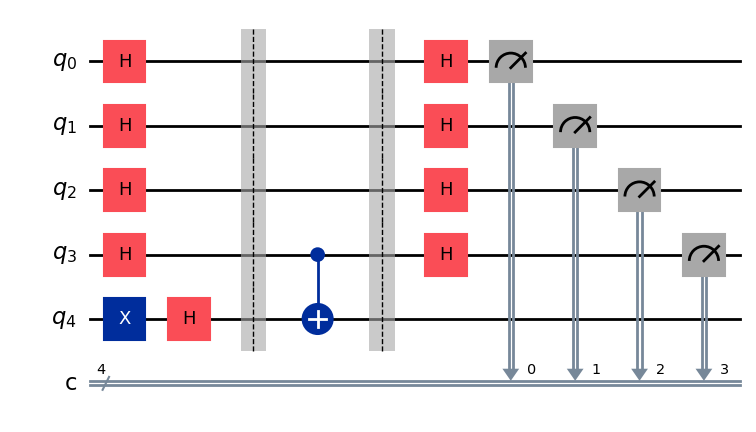

In [18]:
string = "1000"  # secret string that we'll pretend we don't know or have access to
n = len(string)

qc = QuantumCircuit(n + 1, n)
qc.x(n)
qc.h(range(n + 1))
qc.barrier()
# qc.compose(oracle, inplace = True)
qc.compose(bv_function(string), inplace=True)
qc.barrier()
qc.h(range(n))
qc.measure(range(n), range(n))

qc.draw("mpl")

In [19]:
# Step 2: Transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

qc_isa = pm.run(qc)

In [20]:
# Step 3: Run the job on a real quantum computer

job = sampler.run([qc_isa], shots=1)
# job = sampler_sim.run([qc_isa],shots=1) # uncomment this line to run on simulator instead
res = job.result()
counts = res[0].data.c.get_counts()

# job = sampler_gen.run([qc_isa],shots=1)
# res=job.result()
# counts=res[0].data.c.get_counts()

In [21]:
# Step 4: Visualize and analyze results

## Analysis
print(counts)

{'0000': 1}


So, with just a single query, the Deutsch-Jozsa algorithm will return the string $s$ used in the function: $f(x)=x \cdot s$ when we apply it to the Bernstein-Vazirani problem. With a classical algorithm, one would need $n$ queries to solve the same problem.

## 5. Conclusion

We hope that by examining these simple examples, we've given you a better intuition for how quantum computers are able to harness superposition, entanglement, and interference to achieve their power over classical computers.

The Deutsch-Jozsa algorithm has huge historical importance because it was the first to demonstrate any speedup over a classical algorithm, but it was only a polynomial speedup. The Deutsch-Jozsa algorithm is just the beginning of the story.

After they used the algorithm to solve their problem, Bernstein and Vazirani used this as the basis for a more complicated, recursive problem called the *recursive Fourier sampling problem*. Their solution offered a super-polynomial speedup over classical algorithms. And even before Bernstein and Vazirani, Peter Shor had already come up with his famous algorithm that enabled quantum computers to factor large numbers exponentially faster than any classical algorithm could. These results, collectively showed the exciting promise of future quantum computer, and spurred physicists and engineers to make this future a reality.

## 6. Review and questions

### Critical concepts
- the Deutsch and Deutsch-Jozsa algorithms use quantum parallelism combined with interference to find an answer to a problem faster than a classical computer can.
- the phase kickback mechanism is a couterintuitive quantum phenomena that transfers operations on one qubit to the phase of another qubit. The Deutsch and Deutsch-Jozsa algorithms utilize this mechanism.
- The Deutsch-Jozsa algorithm offers a polynomial speedup over any deterministic classical algorithm.
- The Deutsch-Jozsa algorithm can be applied to a different problem, called the Bernstein-Vazirani problem, to find a hidden string encoded in a function.

### True/false
1. T/F Deutsch's algorithm is a special case of the Deutsch-Jozsa algorithm where the input is a single qubit.
2. T/F The Deutsch and Deutsch-Jozsa algorithms use quantum superposition and interference to achieve their efficiency.
4. T/F The Deutsch-Jozsa algorithm requires multiple function evaluations to determine if a function is constant or balanced.
5. T/F The "Bernstein-Vazirani algorithm" is actually the same as the Deutsch-Jozsa algorithm, applied to a different problem.
6. T/F The Bernstein-Vazirani algorithm can find multiple secret strings simultaneously.



### Short answer

1. How long would it take a classical algorithm to solve the Deutsch-Jozsa problem in the worst case?

2. How long would it take a classical algorithm to solve the Bernstein-Vazirani problem? What speedup does the DJ algorithm offer in this case?

3. Describe the phase-kickback mechanism and how it works to solve the Deutsch-Jozsa and Bernstein-Vazirani problems.

### Challenge problem
1. The Deutsch-Jozsa algorithm: Recall that you had a question above asking you to work out the intermediate qubit states $\pi_1$, and $\pi_2$ of the Deutsch's algorithm. Do the same for the intermediate $n+1$-qubit states $\pi_1$, and $\pi_2$ of the Deutsch-Jozsa algorithm, for the specific case that $n=2$. Then, verify that $\pi_3 = |-\rangle \otimes \sum\limits_{x_0...x_n}(-1)^{f(x_0...x_n)}|x_0 ... x_n\rangle$, again, for the specific case that $n=2$.